In [2]:
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [3]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print('Label names: ', label_names)

Found 12008 files belonging to 41 classes.
Using 9607 files for training.
Using 2401 files for validation.
Label names:  ['background_noise' 'backward' 'cancel' 'close' 'digit' 'direction'
 'disable' 'down' 'eight' 'enable' 'enter' 'five' 'forward' 'four' 'left'
 'move' 'next' 'nine' 'no' 'ok' 'one' 'open' 'options' 'previous'
 'receive' 'record' 'right' 'rotate' 'send' 'seven' 'six' 'start' 'stop'
 'three' 'two' 'undo' 'up' 'yes' 'zero' 'zoom in' 'zoom out']


In [5]:
for audio, label in train_ds.take(1):
  print('Original Audio Shape: ', audio.shape)
  print('Label: ', label)

Original Audio Shape:  (64, 16000, 1)
Label:  tf.Tensor(
[38  1 32 15 10 16 18 18 25  3 38 30  3 23  7 21  2 11 14 25 14  4 18 15
 15 36 26 23 20 14  3 40 35  2 38  9 26 27  4 25 30 19  8  8 35  9 22  8
 17  7 32  9  3 33 34 37 37 24 15 32 28 24 23 15], shape=(64,), dtype=int32)


In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

PARTISI DATASET UNTUK TRAIN, VAL, TEST

In [7]:
# 80% Training, 20% Validation, 20% Test

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for audio, label in train_ds.take(1):
  spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  print(spectrogram.shape)

(64, 124, 129, 1)


In [9]:
def get_spectrogram(audio):
  spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]

  return spectrogram

In [10]:
def make_spec_ds(ds):
  return ds.map(map_func = lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
train_spectrogram_ds = make_spec_ds(train_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [12]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [13]:
for sample_spectrogram, sample_labels in train_spectrogram_ds.take(1):
  break

ARSITEKTUR CNN

In [14]:
input_shape = sample_spectrogram.shape[1:]
num_labels = len(label_names)

# Normalization Layer
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels)
    ]
)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [16]:
model.compile(
    metrics=['accuracy'],
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam()
)

TRAIN MODEL

In [17]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
151/151 [==============================] - 19s 119ms/step - loss: 2.6997 - accuracy: 0.2765 - val_loss: 1.2496 - val_accuracy: 0.6996
Epoch 2/10
151/151 [==============================] - 17s 114ms/step - loss: 1.4854 - accuracy: 0.5629 - val_loss: 0.7289 - val_accuracy: 0.8380
Epoch 3/10
151/151 [==============================] - 17s 112ms/step - loss: 1.0591 - accuracy: 0.6874 - val_loss: 0.4637 - val_accuracy: 0.8835
Epoch 4/10
151/151 [==============================] - 17s 113ms/step - loss: 0.8132 - accuracy: 0.7552 - val_loss: 0.3829 - val_accuracy: 0.8861
Epoch 5/10
151/151 [==============================] - 17s 114ms/step - loss: 0.6825 - accuracy: 0.7917 - val_loss: 0.3210 - val_accuracy: 0.9156
Epoch 6/10
151/151 [==============================] - 17s 113ms/step - loss: 0.5795 - accuracy: 0.8184 - val_loss: 0.2723 - val_accuracy: 0.9266
Epoch 7/10
151/151 [==============================] - 17s 114ms/step - loss: 0.4907 - accuracy: 0.8476 - val_loss: 0.2657 - val_ac

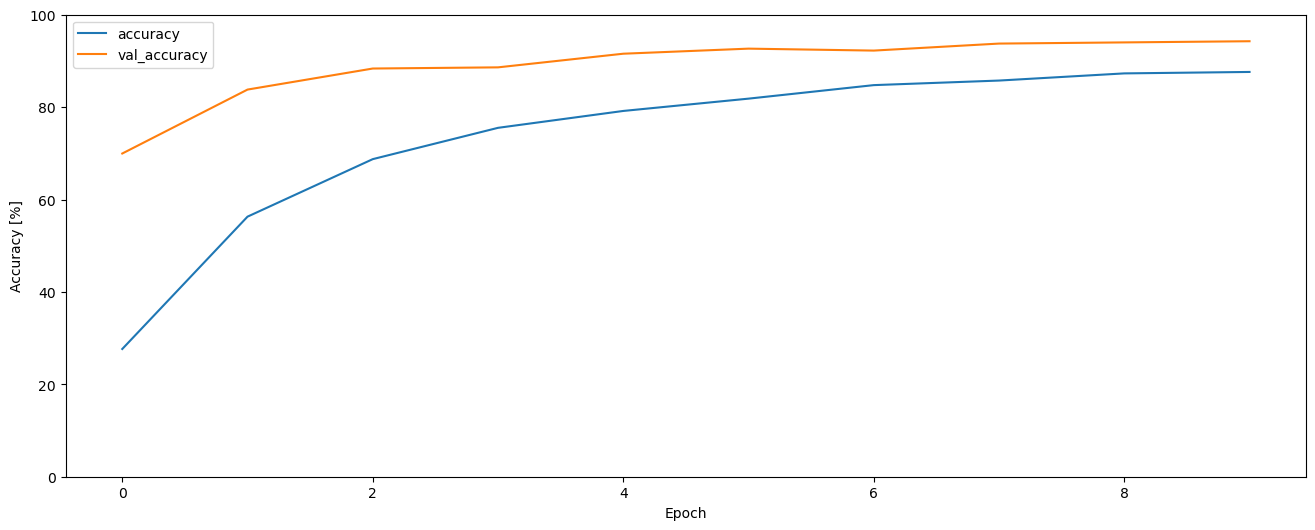

In [18]:
metrics = history.history

plt.figure(figsize=(16,6))
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

PREDICTION

In [19]:
# Get Model Predicitions
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

19/19 [==============================] - 1s 54ms/step


In [20]:
def convert_to_label(labels):
  return [label_names[label.numpy()] for label in labels]

y_pred = convert_to_label(y_pred)
y_true = convert_to_label(tf.concat([label for _, label in test_spectrogram_ds], axis=0))

for index, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
  print(f'Data {index}: Original Label -> {true_label}, Prediction -> {pred_label}')

Data 0: Original Label -> close, Prediction -> close
Data 1: Original Label -> eight, Prediction -> eight
Data 2: Original Label -> nine, Prediction -> previous
Data 3: Original Label -> eight, Prediction -> eight
Data 4: Original Label -> stop, Prediction -> stop
Data 5: Original Label -> options, Prediction -> options
Data 6: Original Label -> nine, Prediction -> nine
Data 7: Original Label -> zoom out, Prediction -> zoom out
Data 8: Original Label -> seven, Prediction -> seven
Data 9: Original Label -> next, Prediction -> previous
Data 10: Original Label -> previous, Prediction -> previous
Data 11: Original Label -> cancel, Prediction -> cancel
Data 12: Original Label -> next, Prediction -> next
Data 13: Original Label -> rotate, Prediction -> rotate
Data 14: Original Label -> backward, Prediction -> enter
Data 15: Original Label -> options, Prediction -> options
Data 16: Original Label -> enable, Prediction -> enable
Data 17: Original Label -> right, Prediction -> right
Data 18: Or

ACCURACY

In [21]:
# Accuracy Test
y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = np.mean(y_true == y_pred)
print('Accuracy on test set: ', accuracy*100)

Accuracy on test set:  92.76315789473685
